In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
%load_ext autoreload
%autoreload 2

import interpolation
from sklearn.pipeline import Pipeline
from category_encoders.target_encoder import TargetEncoder
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from xgboost import plot_tree
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
filled_1850 = pd.read_csv("../data/dwelling_filled_sum_1850_mn.csv")
census_1880 = pd.read_csv("../data/census_1880_mn_blocks.csv")

/Users/tabithasugumar/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
census_1880.reset_index(inplace = True)
filled_1850.dropna(subset = ["CENSUS_DWELLING_NUM"], inplace = True)
filled_1850.rename(columns = {"CENSUS_WARD_NUM":"WARD_NUM", "CENSUS_SERIALP":"CENSUS_SERIALB", "BLOCK_NUM":"block_num"}, inplace = True)

In [4]:
sd_1850 = pd.read_csv("../data/mn_seg_add_range_1850.csv")
sd_1880 = pd.read_csv("../data/mn_seg_add_range_1880.csv")

In [5]:
dwellings_1850, dwellings_1880, census_1850_model, census_1880_model = interpolation.sequence_datasets(filled_1850, census_1880)

/Users/tabithasugumar/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [6]:
census_1880_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1119185 entries, 0 to 1119184
Data columns (total 52 columns):
index                1119185 non-null int64
OBJECTID.x           1119185 non-null int64
CENSUS_MERGEID       1119185 non-null object
CENSUS_SERIALB       1119185 non-null int64
CENSUS_SERIAL        1119185 non-null int64
CENSUS_PERNUM        1119185 non-null int64
CENSUS_RECIDUS       1118864 non-null object
CENSUS_REEL          1119185 non-null int64
CENSUS_VOLUME        1119185 non-null int64
CENSUS_PAGENUM       1119185 non-null int64
CENSUS_NAMEFRSTB     1119185 non-null object
CENSUS_NAMELASTB     1119185 non-null object
CENSUS_RELATE        1119185 non-null int64
CENSUS_RELATE_STR    1119185 non-null object
CENSUS_AGE           1119185 non-null int64
CENSUS_SEXB          1119185 non-null int64
CENSUS_RACENAMEB     1119185 non-null object
CENSUS_RACEB         1119185 non-null int64
CENSUS_NPERHHB       1119185 non-null int64
CENSUS_OCCLABELB     1119028 non-null object


In [7]:
filled_1850_sd = census_1850_model.merge(sd_1850, how = "left", left_on = ["WARD_NUM", "street_name"], right_on = ["ED", "Name"])
census_1880_sd = census_1880_model.merge(sd_1880, how = "left", left_on = ["CENSUS_ENUMDIST", "street_name"], right_on = ["ED", "Name"]) 

In [51]:
#This way it seems that no values in 1850 where we have sequence numbers actually
#have street dictionary information too
cols = ["CENSUS_SERIALB", "street_name", "sequence_id", "Min", "Max", "WARD_NUM", "block_num"]
train_X, train_y, test_1880_X, test_1880_y, test_1850_X, test_1850_y = interpolation.create_train_test_data(census_1880_sd, filled_1850_sd, cols)

In [38]:
#For now let's solve the issue of min/max missing data by imputing 0s
#We can also try mean and med
#We'll target encode everything else, as we did previously
cont = ["Min", "Max"]
target = ["CENSUS_SERIALB", "street_name", "sequence_id", "WARD_NUM", "block_num"]
continuous_pp = make_pipeline(SimpleImputer(strategy = 'constant', fill_value = 0), StandardScaler())
pp = make_column_transformer((continuous_pp, cont),(TargetEncoder(cols = target), target))
model_street = Pipeline([('preprocess', pp),
                        ('regressor', LinearRegression())])

In [39]:
model_street.fit(train_X, train_y)
print("Training Score:", model_street.score(train_X, train_y))
print("1880 Test Score:", model_street.score(test_1880_X, test_1880_y))
print("1850 Test Score:", model_street.score(test_1850_X, test_1850_y))

Training Score: 0.9683320961322633
1880 Test Score: 0.8815927136671617
1850 Test Score: 0.8254134311051209


In [40]:
street_boost = Pipeline([('preprocess', pp),
                         ('regressor', XGBRegressor(objective ='reg:squarederror', learning_rate = 0.1,
                max_depth = 3, n_estimators = 1000, colsample_bytree = 0.5, alpha = 1))])

In [41]:
street_boost.fit(train_X, train_y)
print("Training Score:", street_boost.score(train_X, train_y))
print("1880 Test Score:", street_boost.score(test_1880_X, test_1880_y))
print("1850 Test Score:", street_boost.score(test_1850_X, test_1850_y))

Training Score: 0.9919045775057633
1880 Test Score: 0.974392232215896
1850 Test Score: 0.9593938804965105


In [60]:
test_1850_X_pred = test_1850_X.copy()
test_1850_X_pred["predicted_house_num"] = street_boost.predict(test_1850_X)
test_1850_X_pred["house_number"] = test_1850_y

In [62]:
test_1850_X_pred.iloc[100:130]

,CENSUS_SERIALB,street_name,sequence_id,Min,Max,WARD_NUM,block_num,predicted_house_num,house_number
1767,2044481,Wall,65.0,NaN,NaN,1,718.0,-23.020185,54.0
5909,2045898,Water,165.0,NaN,NaN,1,3785.0,8.303418,11.0
180988,2083755,Bank,6652.0,NaN,NaN,9,230.0,122.160355,115.0
182251,2079046,Hudson,6668.0,NaN,NaN,9,1297.0,418.352112,399.0
199184,2079873,Hudson,7197.0,NaN,NaN,9,1362.0,654.975159,633.0
368569,2124022,W . 19th,13979.0,NaN,NaN,16,1515.0,273.936371,277.0
266633,2092465,Av . B,9334.0,NaN,NaN,11,298.0,49.093933,45.0
151370,2077630,Varick,5682.0,NaN,NaN,8,1099.0,187.943588,191.0
146497,2077292,Watts,5557.0,NaN,NaN,8,103.0,26.894262,16.0
258226,2091819,Pitt,9182.0,NaN,NaN,11,1185.0,107.848175,84.0


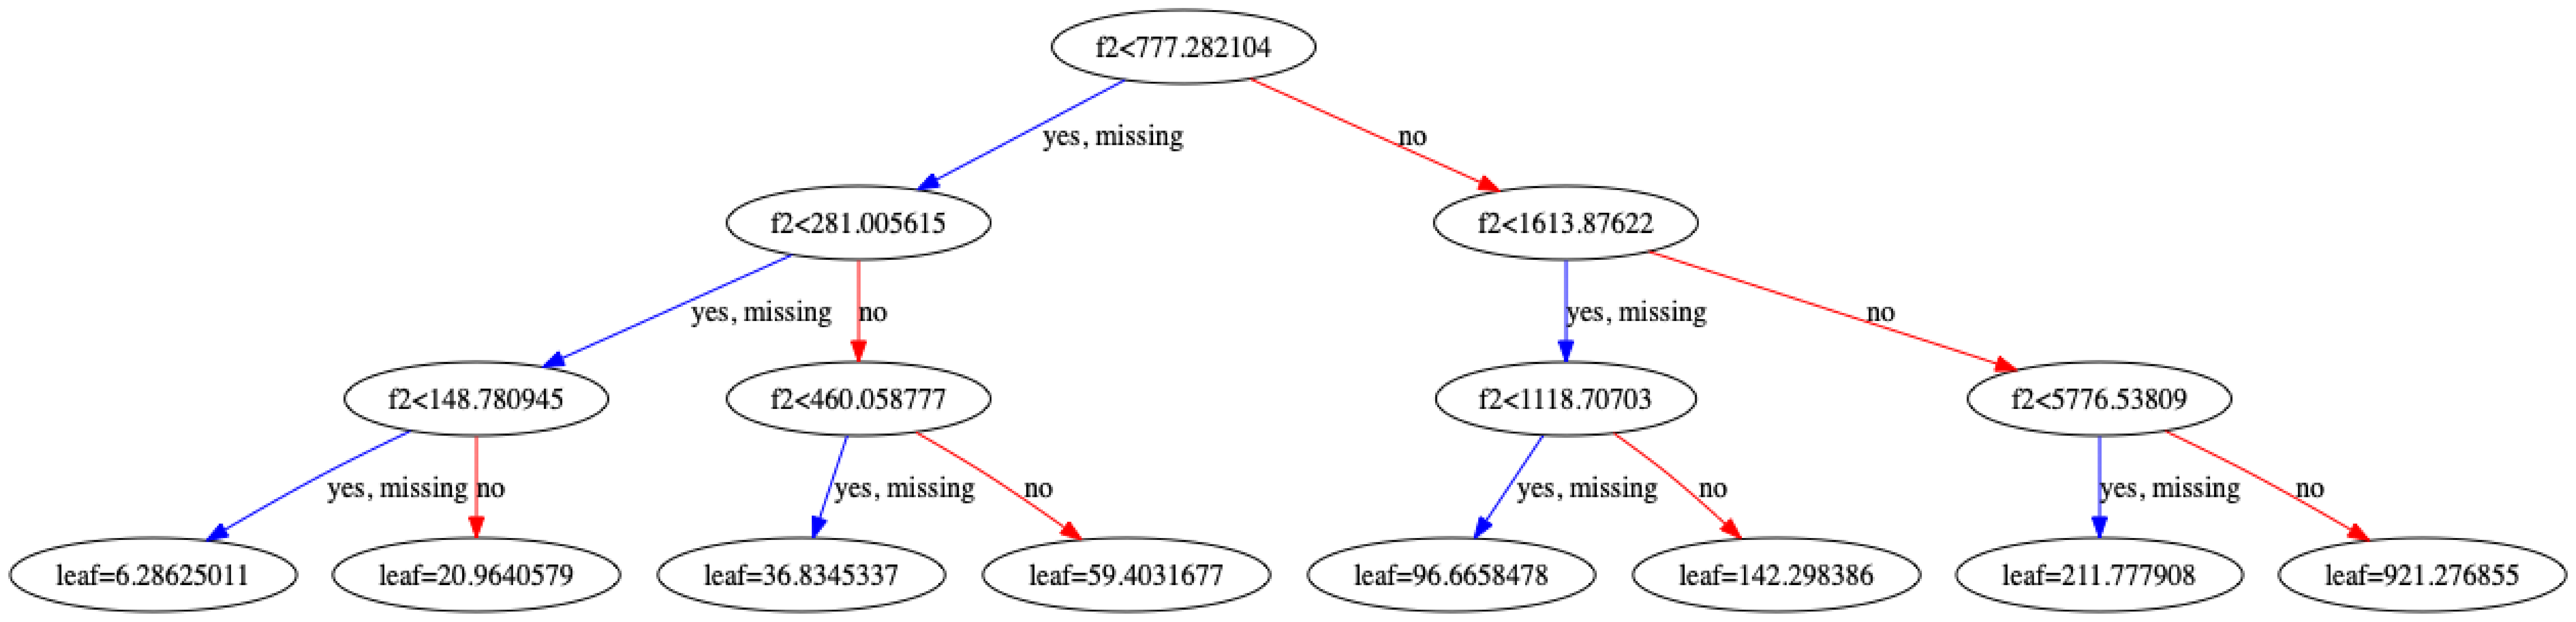

In [43]:
plot_tree(street_boost.named_steps["regressor"])
fig = plt.gcf()
fig.set_size_inches(150, 100)
plt.show()

So adding in the street dictionary improves things slightly, but overall I feel that this is a pretty decent result.

Issues/Questions to consider:
- How well does this actually work
- The disambiguation process accuracy is pretty important since this builds on that
- The importance of SerialB is worrying me a little, I don't understand why it's so important

In [44]:
#Try gradient boosting without serialB
cols = ["street_name", "sequence_id", "Min", "Max", "WARD_NUM", "block_num"]
train_X, train_y, test_1880_X, test_1880_y, test_1850_X, test_1850_y = interpolation.create_train_test_data(census_1880_sd, filled_1850_sd, cols)

In [45]:
cont = ["Min", "Max"]
target = ["street_name", "sequence_id", "WARD_NUM", "block_num"]
continuous_pp = make_pipeline(SimpleImputer(strategy = 'constant', fill_value = 0), StandardScaler())
pp = make_column_transformer((continuous_pp, cont),(TargetEncoder(cols = target), target))

In [46]:
street_boost_noB = Pipeline([('preprocess', pp),
                         ('regressor', XGBRegressor(objective ='reg:squarederror', learning_rate = 0.1,
                max_depth = 3, n_estimators = 1000, colsample_bytree = 0.5, alpha = 1))])

In [47]:
street_boost_noB.fit(train_X, train_y)
print("Training Score:", street_boost_noB.score(train_X, train_y))
print("1880 Test Score:", street_boost_noB.score(test_1880_X, test_1880_y))
print("1850 Test Score:", street_boost_noB.score(test_1850_X, test_1850_y))

Training Score: 0.965931304505066
1880 Test Score: 0.9704871910889998
1850 Test Score: 0.84816060782517


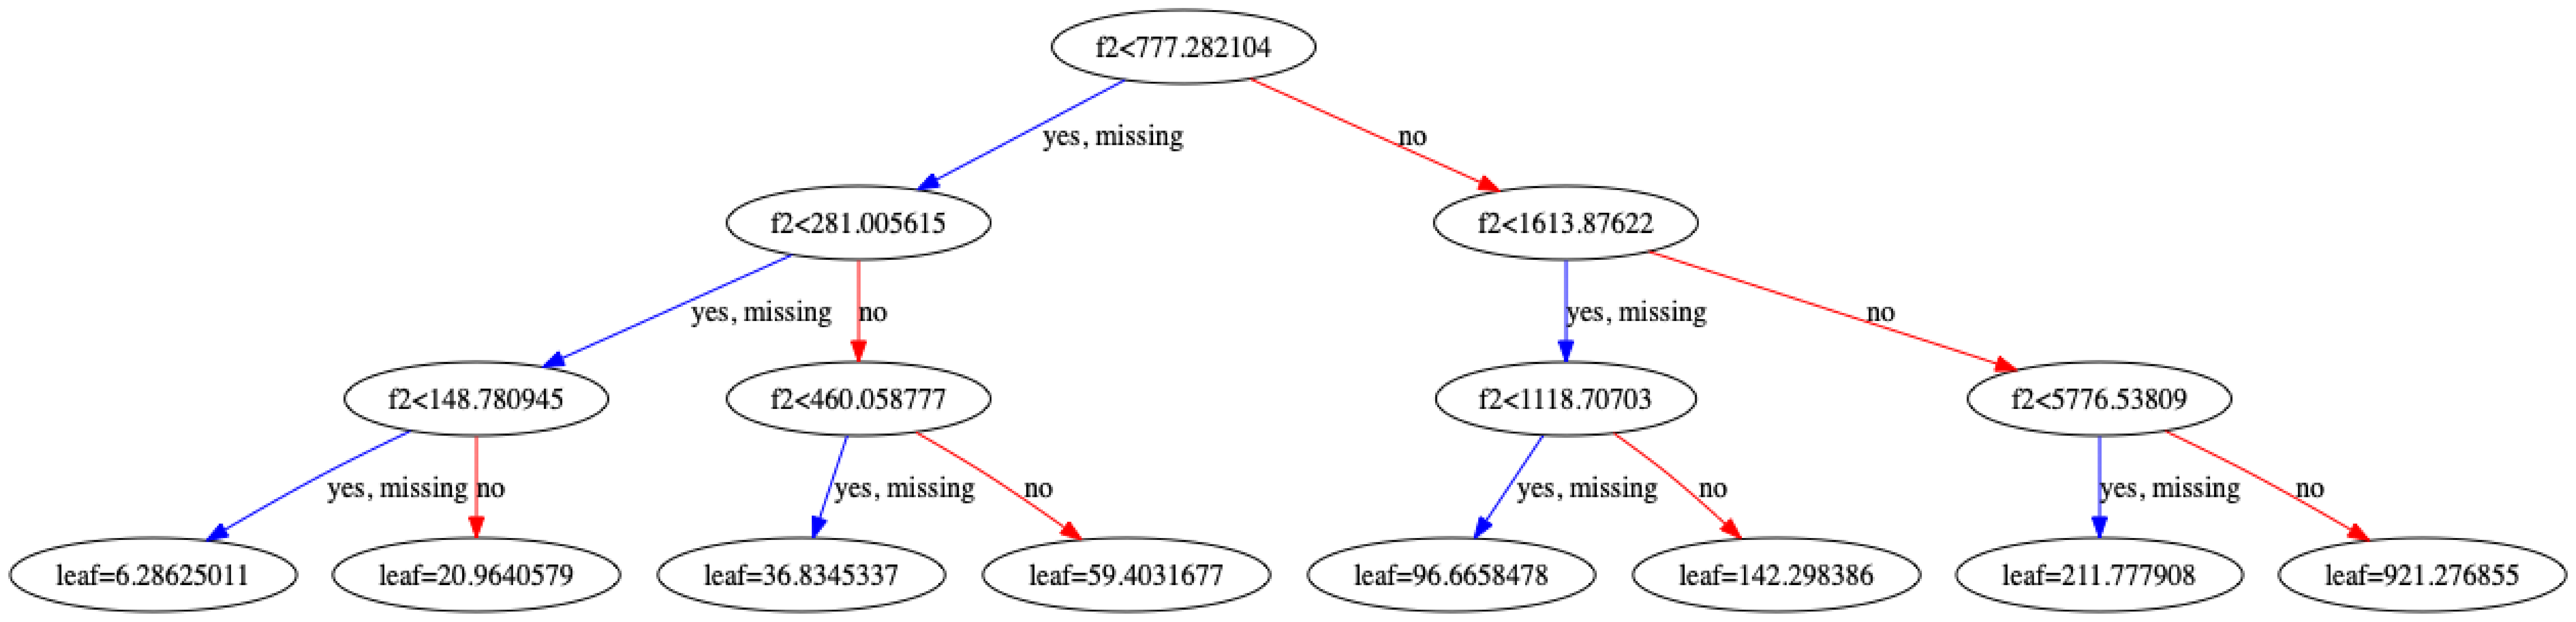

In [48]:
plot_tree(street_boost.named_steps["regressor"])
fig = plt.gcf()
fig.set_size_inches(150, 100)
plt.show()

In [ ]:
#Try with order but withough serialB
cols = ["street_name", "sequence_id", "Min", "Max", "WARD_NUM", "block_num", "sequence_order"]
train_X, train_y, test_1880_X, test_1880_y, test_1850_X, test_1850_y = interpolation.create_train_test_data(census_1880_sd, filled_1850_sd, cols)